# 12장. 군집분석 : 타깃마케팅을 위한 K-평균 군집화

### 1) 데이터 수집

In [1]:
import pandas as pd
import math

In [2]:
retail_df = pd.read_excel('./12장_data/Online_Retail.xlsx')
retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2) 데이터 준비 및 탐색

In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# 오류 데이터 정제
retail_df = retail_df[retail_df['Quantity'] > 0] 
retail_df = retail_df[retail_df['UnitPrice'] > 0] 
retail_df = retail_df[retail_df['CustomerID'].notnull()] 

# 'CustomerID' 자료형을 정수형으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [5]:
retail_df.info()
print(retail_df.isnull().sum())
print(retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(397884, 8)


In [6]:
# 중복 레코드 제거
retail_df.drop_duplicates(inplace=True)

print(retail_df.shape) #작업 확인용 출력

(392692, 8)


#### - 제품 수, 거래건 수, 고객 수 탐색

In [7]:
pd.DataFrame([{'Product':len(retail_df['StockCode'].value_counts()),
              'Transaction':len(retail_df['InvoiceNo'].value_counts()),
              'Customer':len(retail_df['CustomerID'].value_counts())}], 
             columns = ['Product', 'Transaction', 'Customer'],
            index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [8]:
retail_df['Country'].value_counts()

Country
United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [9]:
# 주문금액 컬럼 추가
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### - 고객의 마지막 주문후 경과일(Elapsed Days), 주문횟수(Freq), 주문 총액(Total Amount) 구하기

In [10]:
aggregations = {    
    'InvoiceNo':'count',
    'SaleAmount':'sum',
    'InvoiceDate':'max'
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations)
customer_df = customer_df.reset_index()

customer_df.head()  #작업 확인용 출력

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [11]:
# 컬럼이름 바꾸기
customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'})

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


#### - 마지막 구매후 경과일 계산하기

In [12]:
import datetime 

customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays']

customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00
3,12349,73,1757.55,18 days 14:09:00
4,12350,17,334.40,310 days 07:59:00


In [13]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days+1)
customer_df.head() #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


#### - 현재 데이터 값의 분포 확인하기

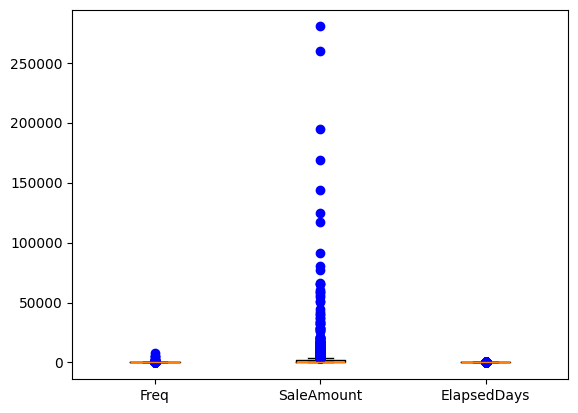

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym='bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount','ElapsedDays' ])

plt.show()

#### - 데이터 값의 왜곡(치우침)을 줄이기 위한 작업 : 로그 함수로 분포 조정

In [15]:
import numpy as np

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805
3,12349,73,1757.55,19,4.304065,7.472245,2.995732
4,12350,17,334.40,311,2.890372,5.815324,5.743003


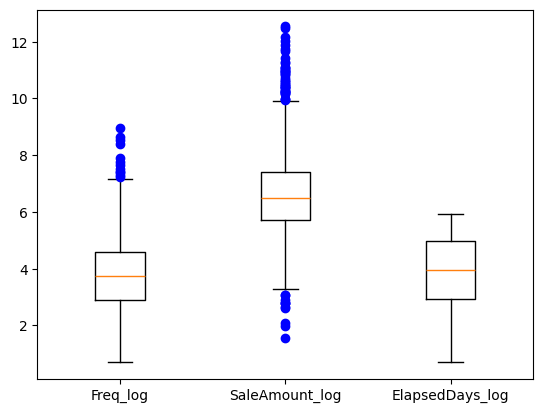

In [16]:
# 조정된 데이터 분포를 다시 박스플롯으로 확인하기
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'],customer_df['ElapsedDays_log']], sym='bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

### 3) 모델 구축 : K-평균 군집화 모델 

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [18]:
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [19]:
# 정규 분포로 다시 스케일링하기
from sklearn.preprocessing import StandardScaler

X_features_scaled = StandardScaler().fit_transform(X_features)

### - 최적의 k 찾기 (1) 엘보우 방법

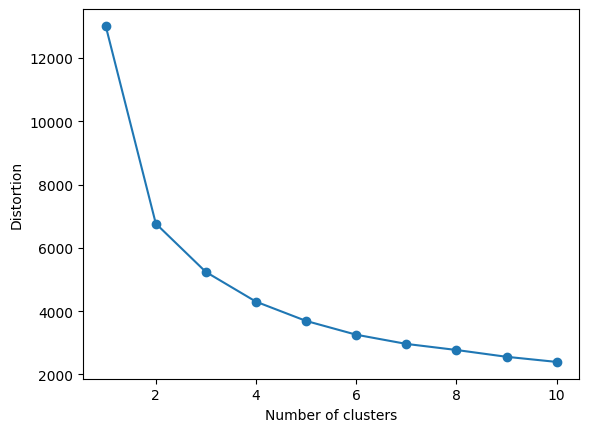

In [20]:
distortions = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=0, n_init='auto')  # 모델 생성
    kmeans_i.fit(X_features_scaled)   # 모델 훈련
    distortions.append(kmeans_i.inertia_)
    
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto') # 모델 생성

# 모델 학습과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled) 

In [22]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()  #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,2
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,2
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0


## 4) 결과 분석 및 시각화

### - 최적의 k 찾기 (2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의

In [23]:
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init='auto')
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

### - 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의

In [24]:
def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init='auto')
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       
    
    #각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

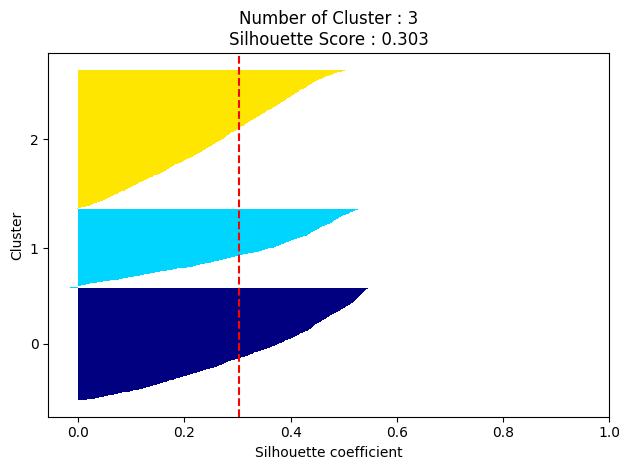

In [25]:
silhouetteViz(3, X_features_scaled) #클러스터 3개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

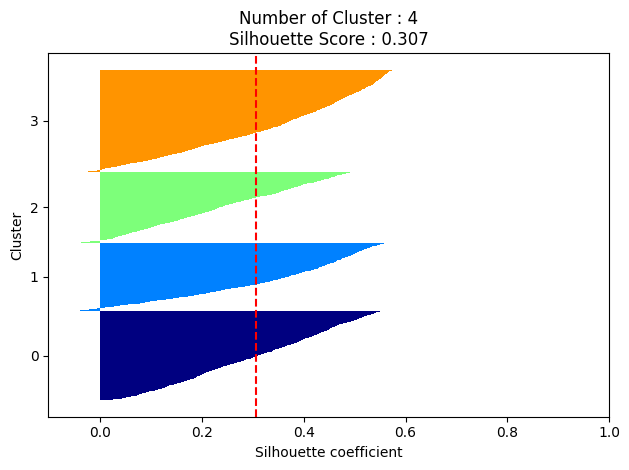

In [26]:
silhouetteViz(4, X_features_scaled) #클러스터 4개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

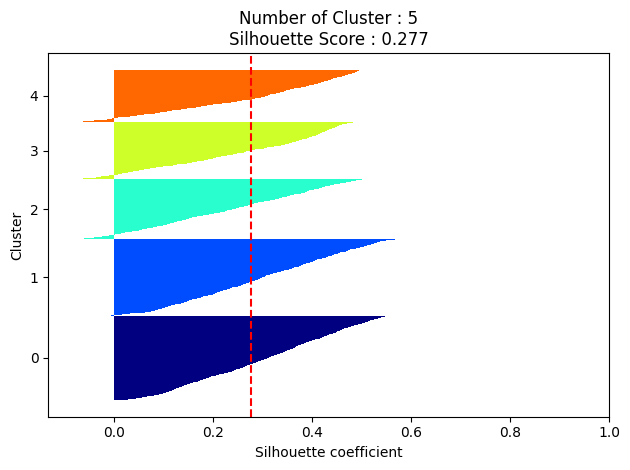

In [27]:
silhouetteViz(5, X_features_scaled) #클러스터 5개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

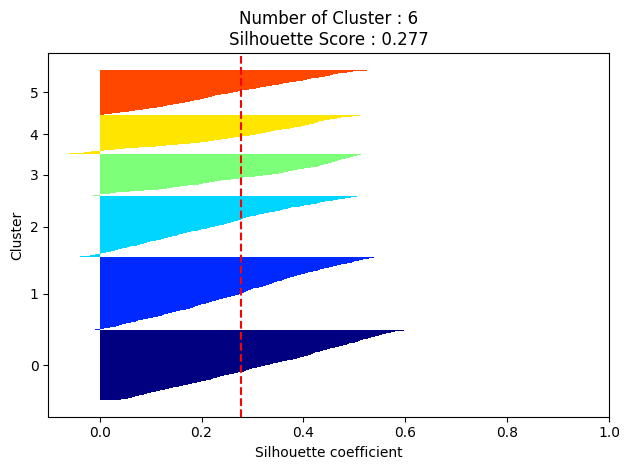

In [28]:
silhouetteViz(6, X_features_scaled) #클러스터 6개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

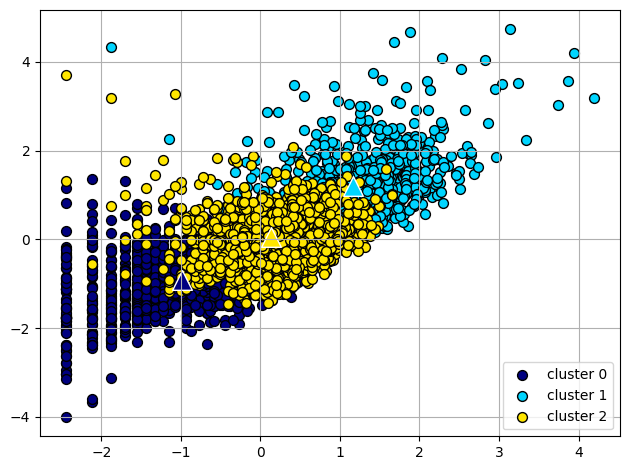

In [29]:
clusterScatter(3, X_features_scaled) #클러스터 3개인 경우의 클러스터 데이터 분포 시각화

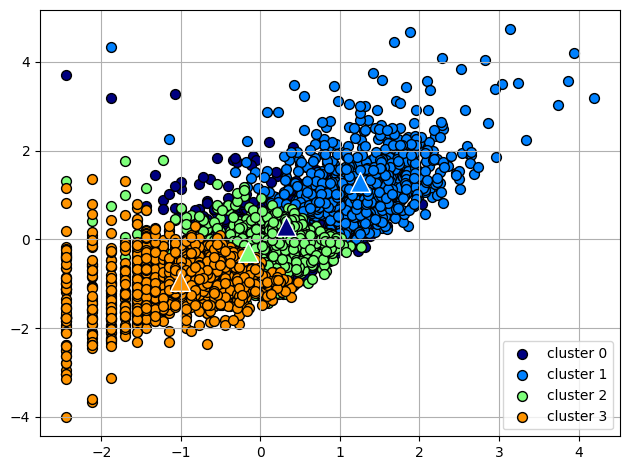

In [30]:
clusterScatter(4, X_features_scaled)  #클러스터 4개인 경우의 클러스터 데이터 분포 시각화

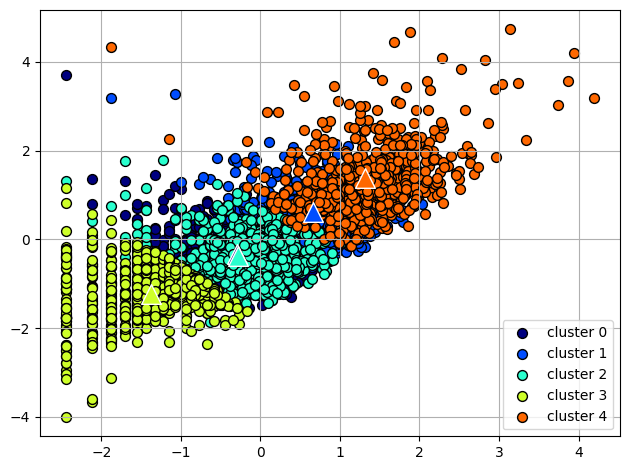

In [31]:
clusterScatter(5, X_features_scaled)  #클러스터 5개인 경우의 클러스터 데이터 분포 시각화

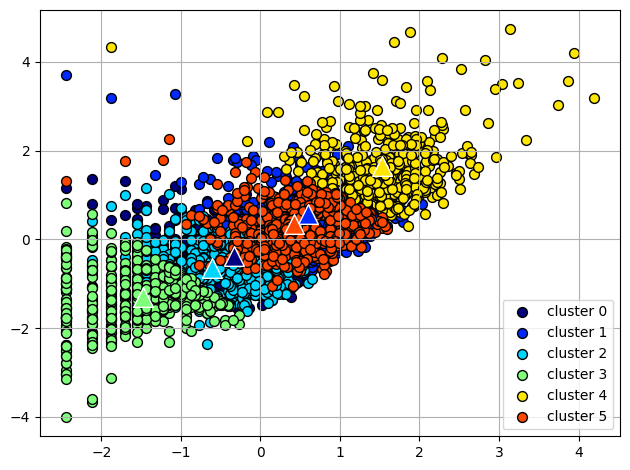

In [32]:
clusterScatter(6, X_features_scaled)  #클러스터 6개인 경우의 클러스터 데이터 분포 시각화

### 결정된 k를 적용하여 최적의 K-mans 모델 완성

In [33]:
best_cluster = 4

kmeans = KMeans(n_clusters=best_cluster, random_state=0, n_init='auto')
Y_labels = kmeans.fit_predict(X_features_scaled)

In [34]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()   #작업 확인용 출력

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,0
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,0
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,1
4,12350,17,334.40,311,2.890372,5.815324,5.743003,3


#### - ClusterLabel이 추가된 데이터를 파일로 저장

In [35]:
customer_df.to_csv('./12장_data/Online_Retail_Customer_Cluster.csv')

## << 클러스터 분석하기 >>

### 1) 각 클러스터의 고객수 

In [36]:
customer_df.groupby('ClusterLabel')['CustomerID'].count()

ClusterLabel
0    1167
1     900
2     931
3    1340
Name: CustomerID, dtype: int64

### 2) 각 클러스터의 특징

In [37]:
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'],axis=1, inplace=False)

In [38]:
# 주문 1회당 평균 구매금액 : SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']

customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel,SaleAmountAvg
0,12346,1,77183.60,326,0,77183.600000
1,12347,182,4310.00,3,1,23.681319
2,12348,31,1797.24,76,0,57.975484
3,12349,73,1757.55,19,1,24.076027
4,12350,17,334.40,311,3,19.670588


In [39]:
# 클러스터별 분석
customer_cluster_df.drop(['CustomerID'],axis=1, inplace=False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,74.443873,1453.809907,106.652956,106.760512
1,275.008889,6901.516111,14.833333,94.322099
2,41.978518,643.460173,20.473684,31.243547
3,14.347761,283.721501,184.191791,43.337452
